In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.graph.edge import Edge
from autocnet.matcher.matcher import FlannMatcher

from autocnet.matcher import subpixel as sp 
from scipy.misc import imresize
import math
import warnings
import cv2

from bisect import bisect_left

from scipy.ndimage.interpolation import rotate

from IPython.display import display
warnings.filterwarnings('ignore')

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Create Basic Structures

In [7]:
#Point to the adjacency Graph
adjacency = get_path('three_image_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)

#Apply SIFT to extract features
cg.extract_features(method='sift', extractor_parameters={'nfeatures':500})

#Match
cg.match_features()

# Perform the symmetry check
cg.symmetry_checks()
# Perform the ratio check
cg.ratio_checks(clean_keys = ['symmetry'])
# Create fundamental matrix
cg.compute_fundamental_matrices(clean_keys = ['symmetry', 'ratio'])


# Step: Compute the homographies and apply RANSAC
cg.compute_homographies(clean_keys=['symmetry', 'ratio'])

# Step: Compute the overlap ratio and coverage ratio
for s, d, edge in cg.edges_iter(data=True):
    edge.coverage_ratio(clean_keys=['symmetry', 'ratio'])

# Step: Compute subpixel offsets for candidate points
cg.subpixel_register(clean_keys=['ransac'])

cg.suppress(clean_keys=['symmetry', 'ratio', 'subpixel'])

# Define Stuff

In [226]:
from copy import deepcopy
from autocnet.matcher.matcher import pattern_match

def cartesian_product(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian_product(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

def corr_normed(template, search):
    if(len(template) < len(search)):
        search = search[:len(template)]
    elif(len(template) > len(search)):
        template = template[:len(search)]
    
    # get averages
    template_avg = np.average(template)
    search_avg = np.average(search)
    
    # compute mean-corrected vetcors
    mc_template = [x-template_avg for x in template]
    mc_search = [x-search_avg for x in search]
    
    # Perform element-wise multiplication 
    arr1xarr2 = np.multiply(mc_template, mc_search)
    
    # element-wise divide by the mangitude1 x magnitude2
    # and return the result
    std1xstd2 = numpy.std(template) * numpy.std(search)
    
    coeffs = [(x/std1xstd2) for x in arr1xarr2]
    return np.average(coeffs)
    
    
def to_polar_coord(shape, center):
    '''
    Generate a polar coordinate grid from a shape given
    a center.
    
    parameters
    ----------
    shape : tuple
            tuple decribing the desired shape in
            (y,x)
    
    center : tuple
             tuple describing the desired center 
             for the grid
    
    returns
    -------
    r2 : ndarray
         grid of radii from the center
    
    theta : ndarray
            grid of angles from the center
    
    '''
    y,x = np.ogrid[:shape[0],:shape[1]]
    cy,cx = center
    tmin,tmax = (0,2*math.pi)

    # ensure stop angle > start angle
    if tmax < tmin:
        tmax += 2*np.pi

    # convert cartesian --> polar coordinates
    r2 = (x-cx)*(x-cx) + (y-cy)*(y-cy)
    theta = np.arctan2(x-cx,y-cy) - tmin

    # wrap angles between 0 and 2*pi
    theta %= (2*np.pi)
    
    return r2, theta


def circ_mask(shape,center,radius):
    '''
    Generates a circular mask
    
    parameters
    ----------
    shape : tuple
            tuple decribing the desired mask shape in
            (y,x) 
            
    center : tuple
             tuple describing the desired center 
             for the circle
    
    radius : float
             radius of circlular mask
    
    returns
    -------
    
    mask : ndarray
           circular mask of bools
    '''
    
    r, theta = to_polar_coord(shape, center)
    
    circmask = r == radius*radius
    anglemask = theta <= 2*math.pi
        
    return circmask*anglemask


def radial_line_mask(shape, center, radius, alpha=0.19460421, atol=.01):
    '''
    Generates a linear mask from center at angle alpha.
    
    parameters
    ----------
    shape : tuple
            tuple decribing the desired mask shape in
            (y,x)
            
    center : tuple
             tuple describing the desired center 
             for the circle
    
    radius : float
             radius of the line mask
             
    alpha : float
            angle for the line mask
    
    atol : float
           absolute tolerance for alpha, the higher
           the tolerance, the wider the angle bandwidth
           
    returns
    -------
    
    mask : ndarray
           linear mask of bools
    '''
    
    r, theta = to_polar_coord(shape, center)
    
    line_mask = r <= radius**2
    anglemask = numpy.isclose(theta, alpha, atol=atol)
        
    return line_mask*anglemask
    
def cifi(template, search_image, thresh=95, use_percentile=True,
         radii=list(range(1,12)), scales=[0.5, 0.57, 0.66,  0.76, 0.87, 1.0]):
    '''
        Circular sampling filter (Cifi) uses projections of the template and search
        images on a set of circular rings to detect the first grade candidate pixels
        and the points' corresponding best fit scales for Ciratefi.
        
        A set of scales is applied to the template and is radially sampled for each radii
        'r' passed in. The template sample is equal to sum of the grayscale values 
        divided by 2*pi*r.
        
        Each pixel in the search image is similarly sampled. Every pixel then gets
        correlated with the template samples at all scales. The scales with the highest
        correlation are the considered the 'best fit scales'.
        
        parameters
        ----------
        template : ndarray
                   The input search template used to 'query' the destination
                   image

        image : ndarray
                The image or sub-image to be searched
        
        thresh : float
                 The correlation thresh hold above which a point will
                 be a first grade candidate point. If use_percentile=True
                 this will act as a percentile, for example, passing 90 means 
                 keep values in the top 90th percentile
        
        use_percentile : bool
                         If True (default), thresh is a percentile instead of a hard 
                         strength value
        
        radii : list
                The list of radii to use for radial sampling
        
        scales : list
                 The list of scales to be applied to the template image, best if 
                 a geometric series
                
        returns
        -------
        fg_candidate_pixels : 1darray
                              array of pixels that passed the filter in tuples (y,x)
        
        best_scales : 1darray
                      parrallel array of best scales for the first grade candidate points
    '''
    if template.shape > search_image.shape:
        raise ValueError('Template Image is smaller than Search Image for template of size: {} and search image of size: {}'\
                          .format(template.shape, search_image.shape))
    
    # Cifi -- Circular Sample on Template
    template_result = np.empty((len(scales), len(radii)))
    
    for i, s in enumerate(scales):
        scaled_img = imresize(template, s)
        for j, r in enumerate(radii):
            # Generate a circular mask
            a, b = (int(scaled_img.shape[0] / 2),
                    int(scaled_img.shape[1] / 2))
            
            if r > b or r > a:
                s =-1
            
            mask = circ_mask(scaled_img.shape, (a,b), r)
            
            inv_area = 1 / (2 * math.pi * r)
            s = np.sum(scaled_img[mask]) * inv_area
            if s == 0:
                s = -1
            template_result[i,j] = s
    
    # Cifi2 -- Circular Sample on Target Image
    search_result = np.empty((search_image.shape[0], search_image.shape[1], len(radii)))
    
    for i, y in enumerate(range(search_image.shape[0])):
        for j, x in enumerate(range(search_image.shape[1])):
            for k, r in enumerate(radii):
                inv_area = 1 / (2 * math.pi * r)
                
                mask = circ_mask(search_image.shape, (i,j), r)
                s = np.sum(search_image[mask]) * inv_area
                
                if s == 0 or y<r or x<r or y+r>search_image.shape[0] or x+r>search_image.shape[1]:
                    s = -1
                search_result[i, j, k] = s
    
    # Perform Normalized Cross-Correlation between template and target image
    coeffs = np.empty((search_result.shape[0], search_result.shape[1]))
    best_scales = np.empty((search_result.shape[0], search_result.shape[1]))
    
    for y in range(search_result.shape[0]):
        for x in range(search_result.shape[1]):
            scale = 0
            max_coeff = -math.inf
            for i in range(template_result.shape[0]):
        
                max_corr = corr_normed(template_result[i], search_result[y,x])
                #result = cv2.matchTemplate(template_result[i].astype(np.float32), search_result[y,x].astype(np.float32), method=cv2.TM_CCOEFF_NORMED)
                #min_corr, max_corr, min_loc, max_loc = cv2.minMaxLoc(result)
                
                if max_corr > max_coeff:
                    max_coeff = max_corr
                    scale = i
        
            coeffs[y,x] = max_coeff
            best_scales[y,x] = scales[scale]
    
    pylab.imshow(coeffs, interpolation='none')
    pylab.show()
    
    a, b = (int(search_image.shape[0] / 2),
        int(search_image.shape[1] / 2))
    
    print('Image Location: ', (a,b))
    print('Correlation at Image Location: ', coeffs[a,b])
    
    # get first grade candidate points
    t1 = thresh if not use_percentile else np.percentile(coeffs, thresh) 
    fg_candidate_pixels = np.array([(y,x) for (y,x),coeff in np.ndenumerate(coeffs) if coeff>=t1])
    
    if(fg_candidate_pixels.size == 0):
        raise warnings.warn('Cifi returned empty set.')
    
    #best_scales = np.array([scale for i,scale in enumerate(fg_candidate_pixels)\
    #                        best_scales[fg_candidate_pixels]])
        
    return fg_candidate_pixels, best_scales

def rafi(template, search_image, candidate_pixels, scales, thresh=95, 
         use_percentile=True, alpha=math.pi/16, radii=list(range(1,12))):
    '''
    The seconds filter in Ciratefi, the Radial Sampling Filter (Rafi), uses
    projections of the template image and the search image on a set of radial
    lines to upgrade the first grade the candidate pixels from cefi to 
    seconds grade candidate pixels along with there corresponding best 
    fit rotation.
    
    The template image is radially sampled at angles 0-2*pi at steps alpha and 
    with the best fit radius (largest sampling radius from radii list that fits
    in the template image) 
    
    Sampling for each line equals the sum of the greyscales divided by the
    best fit radius. 
    
    The search image is similarly sampled at each candidate pixel and is correlated
    with the radial samples on the template. The best fit angle is the angle that 
    maximizes this correlation, and the second grade candidate pixels are determined 
    by the strength of the correlation and the passed threshold
    
    parameters
    ----------
    template : ndarray
               The input search template used to 'query' the destination
               image

    image : ndarray
            The image or sub-image to be searched
    
    candidate_pixels : 1darray
                       array of candidate pixels in tuples (y,x), best if 
                       the pixel are the output of Cifi

    scales : list
             The list of best fit scales for each candidate point,
             the length should equal the length of the candidate point
             list

    thresh : float
             The correlation thresh hold above which a point will
             be a first grade candidate point. If use_percentile=True
             this will act as a percentile, for example, passing 90 means 
             keep values in the top 90th percentile

    use_percentile : bool
                     If True (default), thresh is a percentile instead of a hard 
                     strength value

    alpha : float
            A float between 0 & 2*pi, alpha list = np.arange(0, 2*pi, alpha)
    
    radii : list
            The list of radii to use for radial sampling, best if the list
            is the same as the one used for Cifi

    returns
    -------
    sg_candidate_points : 1darray
        
    best_rotation : 1darray
                    Parrallel array of the best fit rotations for each
                    second grade candidate pixel
    '''

    # Rafi 1  -- Get Radial Samples of Template Image
    alpha_list = np.arange(0, 2*pi, alpha)
    template_alpha_samples = np.zeros(len(alpha_list))
    center_y, center_x = (int(template.shape[0] / 2),
                          int(template.shape[1] / 2))
    
    # find the largest fitting radius
    rad_thresh = center_x if center_x <= center_y else center_y
    
    if(rad_thresh >= max(radii)):
        radius = max(radii)
    else:
        radius = radii[bisect_left(radii, rad_thresh)]

    for i in range(len(template_alpha_samples)):
        # Create Radial Line Mask
        mask = radial_line_mask(template.shape, (center_y, center_x), radius, alpha=alpha_list[i])
        
        # Sum the values
        template_alpha_samples[i] = np.sum(template[mask])/radius
        
    # Rafi 2 -- Get Radial Samples of the Search Image for all First Grade Candidate Points
    rafi_alpha_means = np.zeros((len(candidate_pixels), len(alpha_list)))
    
    for i in range(len(candidate_pixels)):
        y, x = candidate_pixels[i]
        
        rad = radius if min(y,x) > radius else min(y,x)
        cropped_search = search_image[y-rad:y+rad+1, x-rad:x+rad+1]
        scaled_img = imresize(cropped_search, scales[y,x])
        
        # Will except if image size too small after scaling 
        try:
            scaled_center_y, scaled_center_x = (math.floor(scaled_img.shape[0]/2),
                                                math.floor(scaled_img.shape[1]/2))
        except:
            rafi_alpha_means[i] = np.negative(np.ones(len(alpha_list)))
            continue
        
        
        for j in range(len(alpha_list)):
            # Create Radial Mask
            mask = radial_line_mask(scaled_img.shape, (scaled_center_y, scaled_center_x), scaled_center_y, alpha=alpha_list[j])
            rafi_alpha_means[i,j] = np.sum(scaled_img[mask])/radius

    coeffs = np.zeros((search_image.shape[0], search_image.shape[1]))
    best_rotation = np.zeros(len(candidate_pixels))
    rafi_coeffs = np.zeros(len(candidate_pixels))
    
    # Perform Normalized Cross-Correlation between template and target image
    for i in range(len(candidate_pixels)):
        maxcoeff = -math.inf
        maxrotate = 0
        y, x = candidate_pixels[i]
        for j in range(len(alpha_list)):
            c_shift_RQ = np.roll(template_alpha_samples, j)
            score = corr_normed(c_shift_RQ, rafi_alpha_means[i])
            
            if score > maxcoeff:
                maxcoeff = score
                maxrotate = j

        coeffs[y,x] = maxcoeff
        rafi_coeffs[i] = maxcoeff
        best_rotation[i] = alpha_list[maxrotate]   
    
    # Get second grade candidate points and best rotation
    t2 = thresh if not use_percentile else np.percentile(rafi_coeffs, thresh) 
    rafi_mask = rafi_coeffs >= t2
    sg_candidate_points = candidate_pixels[rafi_mask]
    best_rotation = best_rotation[rafi_mask]
    
    if(sg_candidate_points.size == 0):
        warnings.warn('Second filter Rafi returned empty set.')
        
    pylab.imshow(coeffs, interpolation='none')
    pylab.show()
    
    return sg_candidate_points, best_rotation
    
def tefi(template, search_image, candidate_pixels, best_scales, best_angles, 
         scales=[0.5, 0.57, 0.66,  0.76, 0.87, 1.0], upsampling=1, thresh=100, 
         alpha=pi/16, use_percentile=True):
    '''
    Template Matching Filter (Tefi) is the third and final filter for ciratefi. 
    
    For every candidate pixel, tefi rotates and scales the template image by the list
    of scales and angles passed in (which, ideally are the output from cefi and rafi
    respectively) and performs template match around the candidate pixels at the 
    approriate scale and rotation angle. Here, the scales, angles and candidate
    points should be a parrallel array structure. 
    
    Any points with correlation strength over the threshold are returned as
    the the strongest candidates for the image location. If knows the point
    exists in one location, thresh should be 100 and use_percentile = True. 
    
    parameters
    ----------
    template : ndarray
               The input search template used to 'query' the destination
               image

    image : ndarray
            The image or sub-image to be searched

    candidate_pixels : 1darray
                       array of candidate pixels in tuples (y,x), best if 
                       the pixel are the output of Cifi

    best_scales : list
                  The list of best fit scales for each candidate point, the length 
                  should equal the length of the candidate point list
    
    best_angles : list
                  The list of best fit rotation for each candidate point in radians, 
                  the length should equal the length of the candidate point list
    
    upsampling : int
                 upsample degree
    
    thresh : float
             The correlation thresh hold above which a point will
             be a first grade candidate point. If use_percentile=True
             this will act as a percentile, for example, passing 90 means 
             keep values in the top 90th percentile

    use_percentile : bool
                     If True (default), thresh is a percentile instead of a hard 
                     strength value
    
    alpha : float
            A float between 0 & 2*pi, alpha list = np.arange(0, 2*pi, alpha)
            
            
    returns
    -------
    
    results : 1darray
              array of pixel tuples (y,x) which over the threshold 
    '''
    
    # Check inputs
    if upsampling < 1:
        raise ValueError('Upsampling must be >= 1, got {}'.format(upsampling))
    
    coeffs = np.zeros((search_image.shape[0], search_image.shape[1]))
    tefi_coeffs = np.zeros(len(candidate_pixels))
    
    # check for upsampling
    if upsampling > 1:
        template = zoom(template, upsampling, order=3)
        search_image = zoom(search_image, upsampling, order=3)
    
    alpha_list = np.arange(0, 2*pi, alpha)
    candidate_pixels *= int(upsampling)
    
    # Tefi -- Template Matching Filter
    for i in range(len(candidate_pixels)):
        y, x = candidate_pixels[i]
        
        best_scale_idx = (where(scales == best_scales[y//upsampling,x//upsampling]))[0][0]
        best_alpha_idx = (where(alpha_list == best_angles[i]))[0][0]
        
        tefi_scales = np.array(scales).take(range(best_scale_idx-1, best_scale_idx+2), mode='wrap')
        tefi_alphas = alpha_list.take(range(best_alpha_idx-1, best_alpha_idx+2), mode='wrap')
        
        scalesXalphas = cartesian_product([tefi_scales, tefi_alphas])
        
        max_coeff = -math.inf
        for j in range(scalesXalphas.shape[0]):
            transformed_template = imresize(template, scalesXalphas[j][0])
            transformed_template = rotate(transformed_template, scalesXalphas[j][1])
            
            y_window, x_window = (math.floor(transformed_template.shape[0]/2),
                                  math.floor(transformed_template.shape[1]/2))
            
            cropped_search = search_image[y-y_window:y+y_window+1, x-x_window:x+x_window+1]
                
            if(y < y_window or x < x_window or cropped_search.shape < transformed_template.shape):
                score = -1
            else:
                score = corr_normed(transformed_template.flatten(), cropped_search.flatten())
                
            if(score > max_coeff):
                max_coeff = score
            
        coeffs[y//upsampling][x//upsampling] = max_coeff
        tefi_coeffs[i] = max_coeff
    
    pylab.imshow(coeffs, interpolation='none')
    pylab.colorbar()
    (y,x) = candidate_pixels[where(tefi_coeffs == max(tefi_coeffs))[0][0]]/upsampling
    #print(coeffs[17, 17])
    print(coeffs[y,x])
    
    t3 = thresh if not use_percentile else np.percentile(tefi_coeffs, thresh)
    results = candidate_pixels[where(tefi_coeffs >=t3)]
    results = results//upsampling
    
    scatter(y=[y],x=[x], c='g', s=40)
    show()
    
    return results
    

def ciratefi(template, search_image, upsampling=1, cifi_thresh=95, rafi_thresh=95, tefi_thresh=100, 
             use_percentile=False, alpha=math.pi/16, 
             scales=[0.5, 0.57, 0.66,  0.76, 0.87, 1.0], radii=list(range(1,12))):
    
    # Perform first filter cifi
    fg_candidate_pixels, best_scales = cifi(template, search_image, thresh=cifi_thresh, 
                                            use_percentile=use_percentile,
                                            scales=scales, radii=radii)
    # Perform second filter rafi
    sg_candidate_points, best_rotation = rafi(template, search_image, fg_candidate_pixels, best_scales, 
                                              thresh = rafi_thresh, use_percentile=use_percentile, alpha=alpha, 
                                              radii=radii)
    
    # Perform last filter tefi
    results = tefi(template, search_image, sg_candidate_points, best_scales, best_rotation, 
                   thresh=100, alpha=pi/4, use_percentile=True, upsampling=upsampling)
    
    # return the points found
    return results

    
    

# Do Stuff

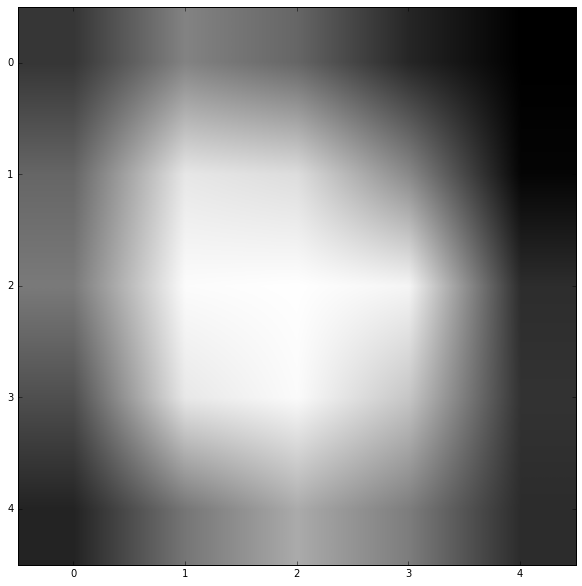

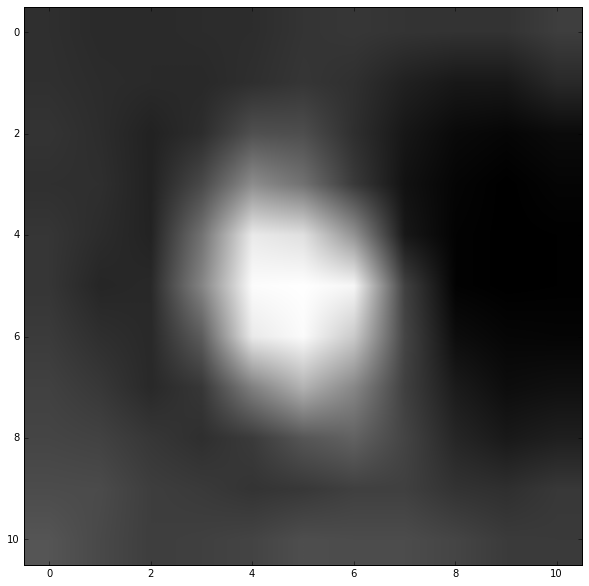

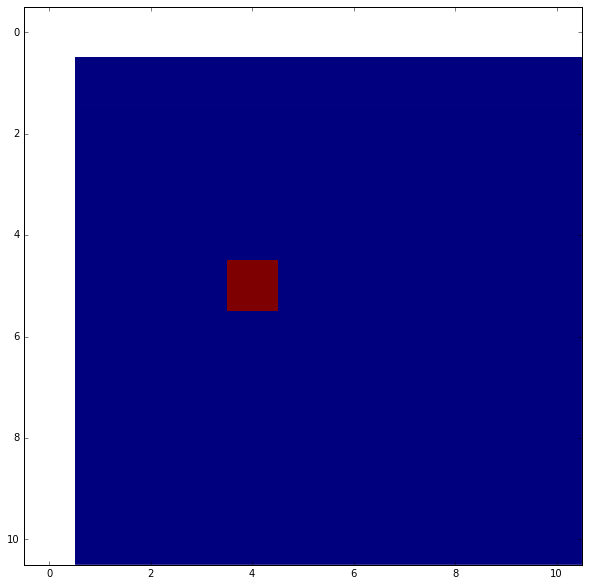

Image Location:  (5, 5)
Correlation at Image Location:  1.0


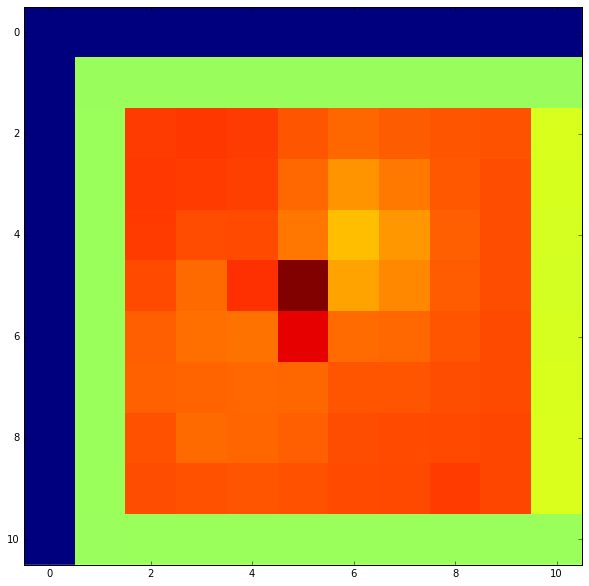

0.816692482545


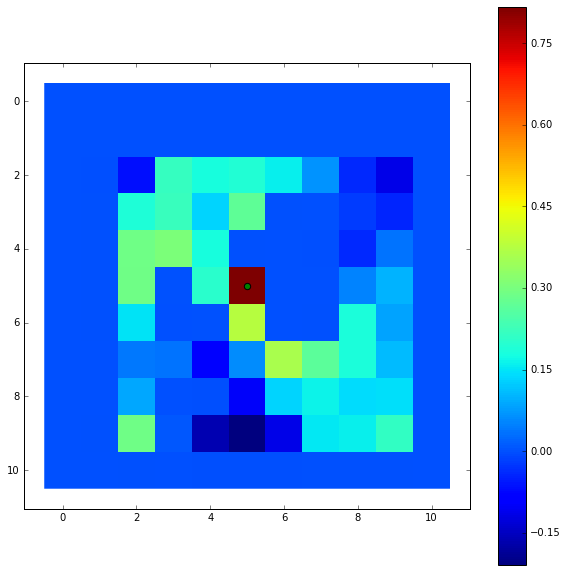

[[ 5.  5.]]


In [237]:
from scipy.ndimage.interpolation import zoom
from scipy.stats.stats import pearsonr 

figsize(10,10)
e = cg.edge[0][1]
matches = e.matches
clean_keys = ['subpixel']

full_offsets = np.zeros((len(matches), 3))

if clean_keys:
    matches, mask = e._clean(clean_keys)

# Preallocate the numpy array to avoid appending and type conversion
edge_offsets = np.empty((len(matches),3))

# for each edge, calculate this for each keypoint pair
for i, (idx, row) in enumerate(matches.iterrows()):
    s_idx = int(row['source_idx'])
    d_idx = int(row['destination_idx'])
    s_kps = e.source.get_keypoints().iloc[s_idx]
    d_kps = e.destination.get_keypoints().iloc[d_idx]

    s_keypoint = e.source.get_keypoints().iloc[s_idx][['x', 'y']].values
    d_keypoint = e.destination.get_keypoints().iloc[d_idx][['x', 'y']].values

    # Get the template and search windows
    s_template = sp.clip_roi(e.source.geodata, s_keypoint, 5)
    s_template = rotate(s_template, 0)
    s_template = imresize(s_template, 1.)

    d_search = sp.clip_roi(e.source.geodata, s_keypoint, 11)
    d_search = rotate(d_search, 0)
    d_search = imresize(d_search, 1.)
    
    imshow(s_template, cmap='Greys')
    show()
    imshow(d_search, cmap='Greys')
    show()
    
    result = ciratefi(s_template, d_search, upsampling=10., alpha=math.pi/8, 
                     cifi_thresh=80, rafi_thresh=50, tefi_thresh=100,
                     use_percentile=True, radii=list(range(1,3)))
    print(result)
    break